# 데이터셋 가져오기

In [1]:
import pandas as pd

df = pd.read_csv('water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [3]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [4]:
df['Potability'].value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

# 결측치 처리

In [5]:
ph_mean_0 = df[df['Potability'] == 0]['ph'].mean(skipna=True)
df.loc[(df['Potability'] == 0) & (df['ph'].isnull()), 'ph'] = ph_mean_0

ph_mean_1 = df[df['Potability'] == 1]['ph'].mean(skipna=True)
df.loc[(df['Potability'] == 1) & (df['ph'].isnull()), 'ph'] = ph_mean_1

sulf_mean_0 = df[df['Potability'] == 0]['Sulfate'].mean(skipna=True)
df.loc[(df['Potability'] == 0) & (df['Sulfate'].isnull()), 'Sulfate'] = sulf_mean_0

sulf_mean_1 = df[df['Potability'] == 1]['Sulfate'].mean(skipna=True)
df.loc[(df['Potability'] == 1) & (df['Sulfate'].isnull()), 'Sulfate'] = sulf_mean_1

trih_mean_0 = df[df['Potability'] == 0]['Trihalomethanes'].mean(skipna=True)
df.loc[(df['Potability'] == 0) & (df['Trihalomethanes'].isnull()), 'Trihalomethanes'] = trih_mean_0

trih_mean_1 = df[df['Potability'] == 1]['Trihalomethanes'].mean(skipna=True)
df.loc[(df['Potability'] == 1) & (df['Trihalomethanes'].isnull()), 'Trihalomethanes'] = trih_mean_1

In [6]:
df['ph'].isnull().sum()

0

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# 데이터 분리

In [8]:
X = df.drop(columns='Potability')
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, stratify=y_train, random_state=0)

In [9]:
X_train.shape, X_val.shape, X_test.shape

((1965, 9), (655, 9), (656, 9))

# Feature Scaling

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

# 최적 파라미터

## RandomizedSearchCV

In [11]:
params = {
    "n_estimators":range(100,1001,100), 
    'max_depth':range(1,11),
    'max_features':range(5, 31, 2) 
}

rfc = RandomForestClassifier(random_state=0)
rs = RandomizedSearchCV(rfc, 
                        params, 
                        scoring='accuracy',
                        cv=4, 
                        n_jobs=-1,
                        n_iter=60)

In [12]:
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'max_depth': range(1, 11),
                                        'max_features': range(5, 31, 2),
                                        'n_estimators': range(100, 1001, 100)},
                   scoring='accuracy')

In [13]:
rs.best_score_

0.78424030930737

In [14]:
rs.best_params_

{'n_estimators': 900, 'max_features': 5, 'max_depth': 8}

In [15]:
df_result = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score')
df_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
27,3.548189,0.021295,0.161216,0.006054,900,5,8,"{'n_estimators': 900, 'max_features': 5, 'max_...",0.752033,0.802444,0.794297,0.788187,0.784240,0.019271,1
55,0.370494,0.001804,0.013252,0.000437,100,5,8,"{'n_estimators': 100, 'max_features': 5, 'max_...",0.747967,0.796334,0.792261,0.794297,0.782715,0.020113,2
0,1.863688,0.008579,0.069710,0.001089,500,5,8,"{'n_estimators': 500, 'max_features': 5, 'max_...",0.750000,0.798371,0.792261,0.788187,0.782205,0.018943,3
21,2.054306,0.014948,0.074957,0.002548,600,5,7,"{'n_estimators': 600, 'max_features': 5, 'max_...",0.741870,0.804481,0.794297,0.786151,0.781700,0.023895,4
56,3.105554,0.008259,0.114254,0.002867,900,5,7,"{'n_estimators': 900, 'max_features': 5, 'max_...",0.741870,0.798371,0.792261,0.788187,0.780172,0.022409,5


In [16]:
best_model = rs.best_estimator_
best_model

RandomForestClassifier(max_depth=8, max_features=5, n_estimators=900,
                       random_state=0)

In [17]:
accuracy_score(y_test, best_model.predict(X_test))

0.7850609756097561

In [18]:
def print_classification_metrics(y, pred, title=None):
    """
    인수로 받은 정답(y), 모델 예측값(pred)를 이용해 분류의 평가지표들을 출력
    출력할 평가지표 : accuracy, recall, precision, f1 score
    [parameter]
        y : ndarray - 정답(Ground Truth)
        pred : ndarray - 모델이 예측한 값
        title : str - 출력 결과들에 대한 제목
    [Return]
    [Exception]
    """
    print('='*50)
    if title:
        print(title)
        print('-'*50)
        print('정확도(Accuracy):', accuracy_score(y, pred))
        print('재현율/민감도(Recall):', recall_score(y, pred))
        print('정밀도(Precision):', precision_score(y, pred))
        print('F1 점수(F1 score):', f1_score(y, pred))
        print('='*50)
        
print_classification_metrics(y_test, best_model.predict(X_test), title='Best Model Test')

Best Model Test
--------------------------------------------------
정확도(Accuracy): 0.7850609756097561
재현율/민감도(Recall): 0.58203125
정밀도(Precision): 0.8142076502732241
F1 점수(F1 score): 0.6788154897494305


In [19]:
fi_rs = best_model.feature_importances_
fi_rs

array([0.22834439, 0.06760322, 0.06185351, 0.07101136, 0.42807084,
       0.03514787, 0.0362481 , 0.03758262, 0.0341381 ])

In [20]:
fi_rs_s = pd.Series(fi_rs, index = X.columns)
fi_rs_s

ph                 0.228344
Hardness           0.067603
Solids             0.061854
Chloramines        0.071011
Sulfate            0.428071
Conductivity       0.035148
Organic_carbon     0.036248
Trihalomethanes    0.037583
Turbidity          0.034138
dtype: float64

<AxesSubplot:>

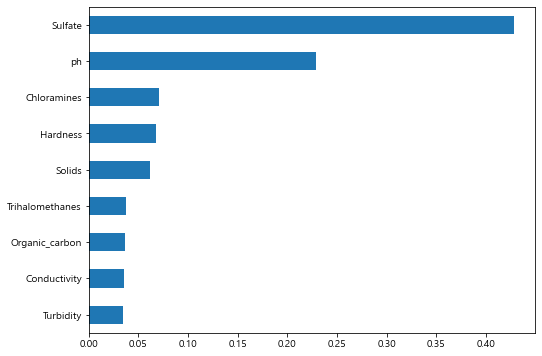

In [21]:
fi_rs_s.sort_values().plot(kind='barh', figsize=(8,6))